# Rotation of a grid

This notebook is to show the ability of ArchPy to use a rotated grid

## Create a reference model

Here an ArchPy reference model is created and used to generate a set of data (boreholes, DEM, geological map) that will be used as inputs to a smaller rotated model

In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
pv.set_jupyter_backend('static')
import sys

#For loading ArchPy, the path where ArchPy is must be added with sys
sys.path.append("../../")
#my modules
from ArchPy.base import * #ArchPy main functions 
from ArchPy.tpgs import * #Truncated plurigaussians

In [2]:
#creating the grid

#grid
sx = 0.3
sy = 0.3
sz = .15
# x1 = 20
# y1 = 10
# z1 = -6
x0 = 0
y0 = 0
z0 = -15
nx = 200
ny = 100
nz = 62
x1 = x0 + sx*nx
y1 = y0 + sy*ny
z1 = z0 + sz*nz

#coordinates vectors
xg = np.linspace(x0,x1,nx+1)
yg = np.linspace(y0,y1,ny+1)
zg = np.linspace(z0,z1,nz+1)

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

#setting a top and a bot
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

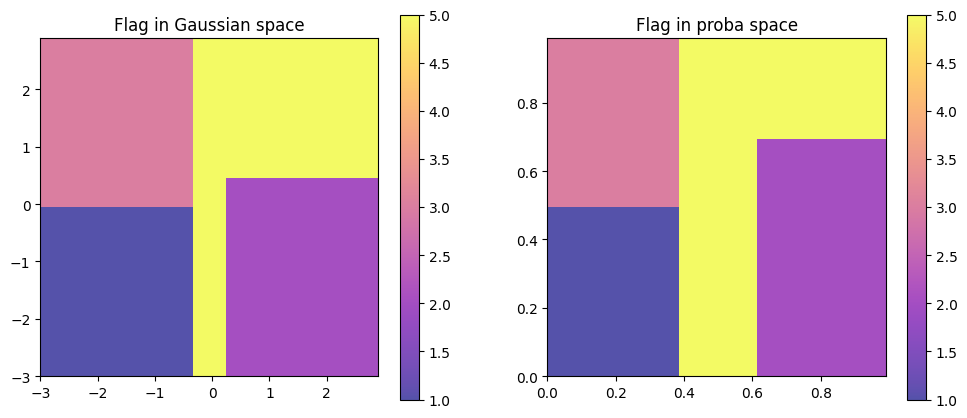

In [3]:
## setup TPGs for D unit

#flag
#thresholds
t2g1 = -0.3
t3g1 = .3
t1g2 = 0
t2g2 = 0.5

#dictionnaries show where a certain facies is present. 
# The structure is a list of list containing 2 tuples of size 2 that indicates the limits of the gaussian fields
# e.g. [[(lower_boundary1_g1,upper_boundary1_g1),(lower_boundary1_g2,upper_boundary1_g2)]] --> this indicates one cuboid and multiple can be defined
dic1 = [[(-np.inf,t2g1),(-np.inf,t1g2)]] # this facies is present between -inf to -0.3 of the 1st gaussian field and between -inf to 0 of the 2
dic2 = [[(t3g1,np.inf),(-np.inf,t2g2)]]
dic3 = [[(-np.inf,t2g1),(t1g2,np.inf)]]
dic4 = [[(t2g1,t3g1),(-np.inf,np.inf)],[(t3g1,np.inf),(t2g2,np.inf)]]

flag = {1:dic1,
        2:dic2,
        3:dic3,
        5:dic4}


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_flag(flag,alpha=.7)
plt.title("Flag in Gaussian space")

plt.subplot(1,2,2)
plot_flag(Gspace2Pspace(flag),alpha=.7)
plt.title("Flag in proba space")

## Gaussian random fields covariance models
G1 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[5.,5.,2.]}),
                         ("nugget",{"w":0.0})],name="G1")
G2 = gcm.CovModel3D(elem=[("spherical",{"w":1.,"r":[10.,10.,5.]}),
                         ("nugget",{"w":0.0})],name="G2",alpha=30)
G_cm = [G1,G2]

A Training image is loaded to be used to fill a unit of the model  with MPS method

In [4]:
# load TI
TI_B = "../../data/TIs/channels3D/ti_channels3D_4f_100x100x60.vtk"
TI_B = geone.img.readImageVtk(TI_B)

#in this example B has four facies which have as ID (1,2,3,5)
TI_B.val = Arr_replace(TI_B.val,{0:3,1:1,2:2,3:5})

## Create units

Four units are created. It is quite similar to the example 3 of the ArchPy list of tutorial "01_basic"

In [5]:
# local proportions for MPS simulation

Z,Y,X = np.meshgrid(zg[:-1],yg[:-1],xg[:-1],indexing='ij')  # meshgrid for the center of the cells

p3_min = 0.1
p3_max = 0.35
p0_min = 0.05
p0_max = 0.15

p3 = (X[:, :, ::-1]/X.max())*(p3_max-p3_min)+p3_min
p3[:,80:,90:] = 0
p3[:,:20,90:] = 0
p1 = 0.8*p3.copy()
p0 = (X[:, :, ::-1]/X.max())*(p0_max-p0_min)+p0_min
p0[:,80:,90:] = 0
p0[:,:20,90:] = 0
p2 = 1 - p0 - p1 - p3

nclass= 4
local_pdf = np.zeros((nclass,nz,ny,nx))
local_pdf[0] = p0
local_pdf[1] = p1
local_pdf[2] = p2
local_pdf[3] = p3

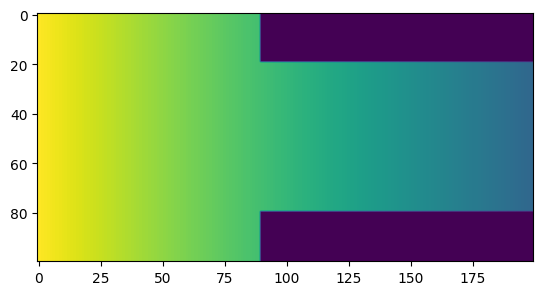

In [6]:
plt.imshow(local_pdf[0][0])

In [7]:
# D unit

covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[6,6]})])
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD, "mean":-5}
dic_f_D = {"f_method" : "TPGs","Flag" : flag,"G_cm":G_cm,"grf_method":"sgs"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.3, 'r':[8,8]})])
dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6}


# C unit
covmodel_SIS_C1 = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[10, 10, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_C2 = gcm.CovModel3D(elem=[("exponential",{"w":.21,"r":[20, 20, 5]})], alpha=45, beta=30, name="vario_SIS") # input variogram
lst_covmodelC=[covmodel_SIS_C1, covmodel_SIS_C2] # list of covmodels to pass at the function

dic_f_C = {"f_method" : "SIS","neig" : 10,"f_covmodel":lst_covmodelC} #facies dic (params)
C = Unit(name="C",
         order=2,
         ID = 2,
         color="blue",
         contact="onlap",
         dic_facies=dic_f_C,
         surface=Surface(dic_surf=dic_s_C,contact="onlap")
        )

#B unit
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[6,6]})])
dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-10}
dic_f_B = {"f_method":"MPS", "TI":TI_B, "xr":0.5,"yr":0.5,"zr":1, "maxscan":0.01, "thresh":0.1,
           "rot_usage":1, "rotAzi":90, "probability":(0.33,0.37,0.2,0.1),"localPdf":local_pdf, "probaUsage":2}
B = Unit(name="B",
         order=3,
         ID = 3,
         color="green",
         contact="onlap",
         dic_facies=dic_f_B,
         surface=Surface(contact="onlap",dic_surf=dic_s_B)
        )

covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[10,10]})])
dic_s_A = {"int_method":"grf_ineq","covmodel": covmodel_er, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",
         order=4,
         ID = 4,
         color="red",
         contact="onlap",
         dic_facies=dic_f_A,
         surface=Surface(dic_surf = dic_s_A,contact="erode"))

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: TI added
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation


In [8]:
#Master pile
P1 = Pile(name="P1")
P1.add_unit([D,C,B,A])

Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


## Facies and properties

In [9]:
#Facies
facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1,facies_2,facies_3,facies_5])
D.add_facies([facies_1,facies_2,facies_3,facies_5])
C.add_facies([facies_4,facies_6])


# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[5,5,1]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[3,3,1]})],alpha=0,name="K_vario_2")
covmodelPoro = gcm.CovModel3D(elem=[("exponential",{"w":0.005,"r":[5,5,5]})],alpha=0,name="poro_vario")

permea = Prop("K",[facies_1,facies_2,facies_3,facies_4,facies_5,facies_6,facies_7],
                  [covmodelK2,covmodelK,covmodelK,None,covmodelK2,covmodelK,None],
                  means=[-3.5,-2,-4.5,-8,-5.5,-6.5,-10],
                  int_method = ["sgs","sgs","sgs","homogenous","sgs","sgs","homogenous"],
                  def_mean=-5)
poro = Prop("Porosity",
            [facies_1,facies_3,facies_4],
            [covmodelPoro,covmodelPoro,covmodelPoro],
             means = [0.4,0.3,0.2],
             int_method = ["sgs","sgs","sgs"],
             def_mean=0.3,
             vmin=0)

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Facies Sand added to unit D
Facies Gravel added to unit D
Facies GM added to unit D
Facies SM added to unit D
Facies Clay added to unit C
Facies Silt added to unit C


In [10]:
ws = "workspace_ref" #working directory
T1 = Arch_table(name = "Example_rotation_ref", seed=1, working_directory=ws)
T1.set_Pile_master(P1) #setting master pile
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot) #grid
T1.rem_all_bhs() #remove previous boreholes if any (not useful in this example)
T1.add_prop([permea, poro]) #add properties

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Standard boreholes removed
Fake boreholes removed
Geological map boreholes removed
Property K added
Property Porosity added


In [11]:
T1.get_sp(facies_kws=["TI", "probability", "localPdf"])[0]

,name,contact,int_method,filling_method,list_facies,TI,probability,localPdf
0,D,onlap,grf_ineq,TPGs,"[Sand, Gravel, GM, SM]",None,None,None
1,C,onlap,grf_ineq,SIS,"[Clay, Silt]",None,None,None
2,B,onlap,grf_ineq,MPS,"[Sand, Gravel, GM, SM]",,"(0.33, 0.37, 0.2, 0.1)",
3,A,erode,grf_ineq,homogenous,[basement],None,None,None


In [20]:
T1.get_sp()[1]

,name,property,mean,covmodels
0,Sand,K,-3.500000,"0: sph (w: 0.1, r: [3, 3, 1])"
1,Sand,Porosity,0.400000,"0: exp (w: 0.005, r: [5, 5, 5])"
2,Gravel,K,-2.000000,"0: exp (w: 0.3, r: [5, 5, 1])"
3,GM,K,-4.500000,"0: exp (w: 0.3, r: [5, 5, 1])"
4,GM,Porosity,0.300000,"0: exp (w: 0.005, r: [5, 5, 5])"
5,SM,K,-5.500000,"0: sph (w: 0.1, r: [3, 3, 1])"
6,Clay,K,-8.000000,None
7,Clay,Porosity,0.200000,"0: exp (w: 0.005, r: [5, 5, 5])"
8,Silt,K,-6.500000,"0: exp (w: 0.3, r: [5, 5, 1])"
9,basement,K,-10.000000,None


In [11]:
T1.compute_surf(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.06253719329833984 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.05578470230102539 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.052326202392578125 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.13537383079528809 s
##########################


### 0.330106258392334: Total time elapsed for computing surfaces ###


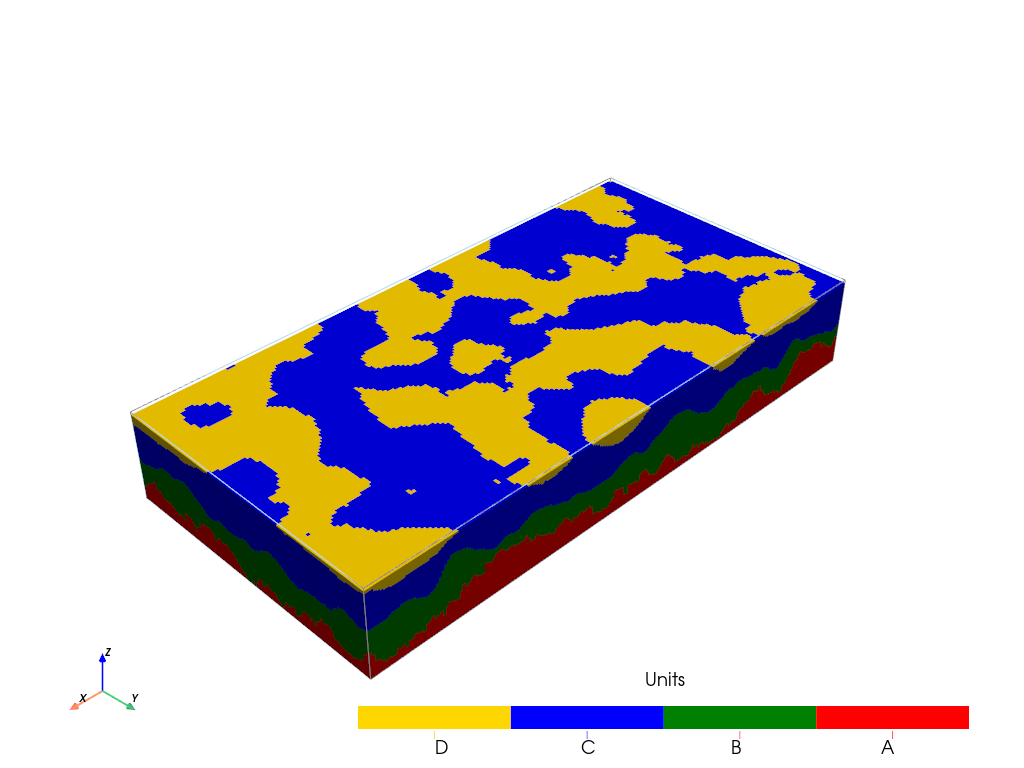

In [13]:
T1.plot_units()

In [14]:
T1.compute_facies(1)


### Unit D: facies simulation with TPGs method ####
### Unit D - realization 0 ###
Time elapsed 0.71 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Time elapsed 3.12 s

### Unit B: facies simulation with MPS method ####
### Unit B - realization 0 ###
Time elapsed 30.42 s

### Unit A: facies simulation with homogenous method ####
### Unit A - realization 0 ###
Time elapsed 0.02 s

### 34.26: Total time elapsed for computing facies ###


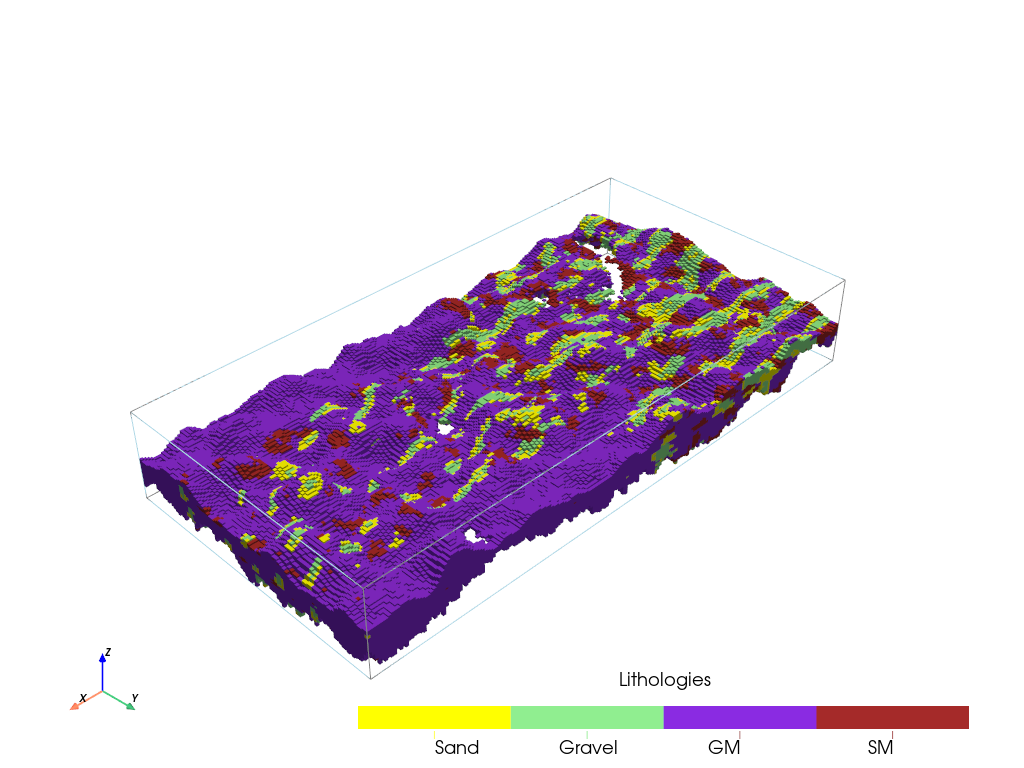

In [21]:
T1.plot_facies(inside_units=[B])

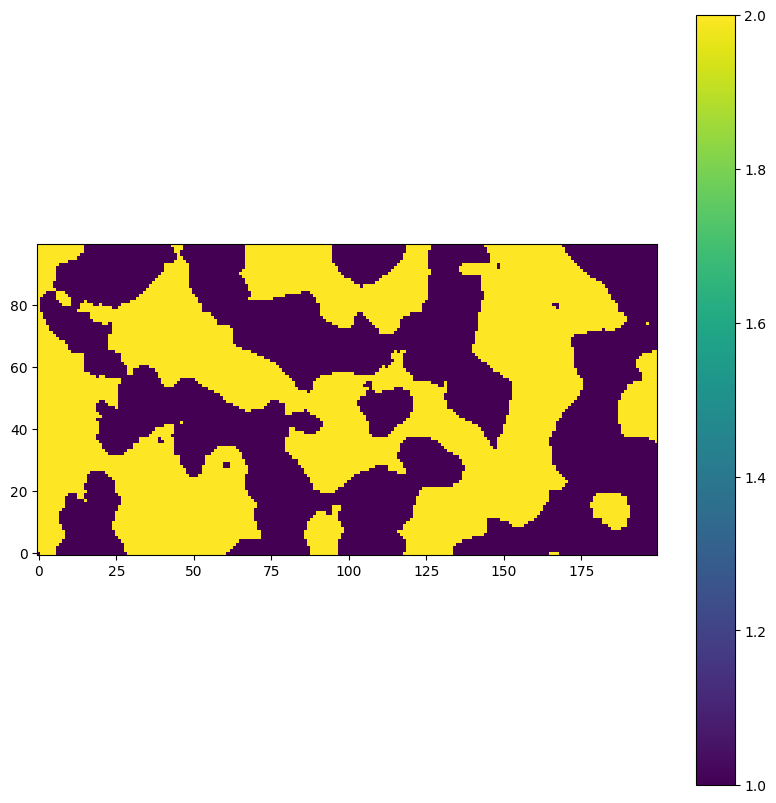

In [30]:
# make a geological map
gmap = T1.compute_geol_map()

plt.figure(figsize=(10,10))
plt.imshow(gmap,origin="lower",cmap="viridis")
plt.colorbar()

# make a raster file
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio import plot

# Define lower left corner coordinates
xllcorner = x0
yllcorner = y0


# Create the raster file 
new_dataset = rasterio.open('geol_map.tif', 'w', driver='GTiff',
                            height = gmap.shape[0], width = gmap.shape[1],
                            transform=from_origin(xllcorner, yllcorner, sx, -sy)
                            ,count=1,dtype=str(gmap.dtype),)

new_dataset.write(gmap, 1)
new_dataset.close()

## Create boreholes from the reference model and setup a new model with a rotated grid

First, fake boreholes are created from the reference model using the function `make_fake_bh()` which takes as entry the x and y positions of the boreholes

In [16]:
import ArchPy

In [17]:
np.random.seed(115)
n=50

x_positions=(np.random.random(size=n) - x0)*x1
y_positions=(np.random.random(size=n) - y0)*y1
l_bhs=T1.make_fake_bh(x_positions, y_positions)[0][0]

for i in range(n):
    l_bhs[i].set_ID(l_bhs[i].ID + str(i))

Let us first setup the grid parameter of the new model and see how it looks on the map

In [18]:
# new model

# grid
nx2 = 215
ny2 = 112
nz2 = 62

Lx2 = 10
Ly2 = 15

ox2 = 25
oy2 = 10

sx2 = Lx2/(nx2)
sy2 = Ly2/(ny2)
sz2 = sz

# rotation
angle = -60

# apply rotation
points = np.array(([ox2, oy2],  [ox2+Lx2, oy2], [ox2+Lx2, oy2+Ly2],[ox2, oy2+Ly2]))

# rotation matrix
np.array([[np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle))],
          [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]])

# remove origin
points = points - np.array([ox2, oy2])

# apply rotation
points = np.dot(points, np.array([[np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle))],
                                  [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]]))

# add origin
points = points + np.array([ox2, oy2])


(-3.0, 63.0, -1.5, 31.5)

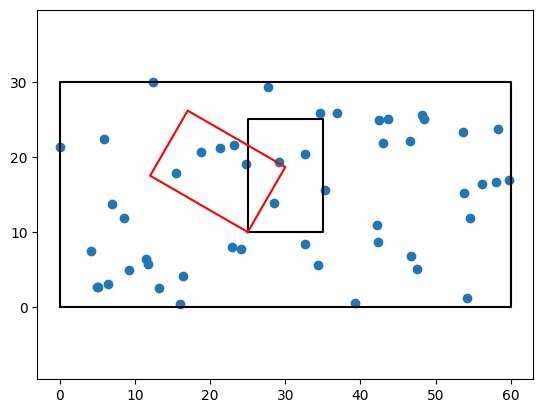

In [19]:
# plot boundaries of the model
plt.plot((x0,x1,x1,x0,x0),(y0,y0,y1,y1,y0),color="black")

plt.scatter(x_positions,y_positions)

# plot new model
plt.plot((ox2,ox2+Lx2,ox2+Lx2,ox2,ox2),(oy2,oy2,oy2+Ly2,oy2+Ly2,oy2),color="black")

# plot rotated model
plt.plot([points[0, 0], points[1, 0], points[2, 0], points[3, 0], points[0, 0]],
            [points[0, 1], points[1, 1], points[2, 1], points[3, 1], points[0, 1]], 'r')

plt.axis("equal")

In [20]:
dimensions2 = (nx2, ny2, nz2)
spacing2 = (sx2, sy2, sz2)
origin2 = (ox2, oy2, z0)

In [21]:
top2 = np.ones([ny2,nx2])*-6
bot2 = np.ones([ny2,nx2])*z0

In [22]:
# create new model
T2 = Arch_table(name = "Example_rotation", seed=1, working_directory=ws)

T2.set_Pile_master(P1) #setting master pile

T2.add_grid((nx2, ny2, nz2), (sx2, sy2, sz2), (ox2, oy2, z0), top = top2, bot=bot2, rotation_angle=-angle) #grid

T2.rem_all_bhs() #remove previous boreholes if any (not useful in this example)

T2.add_bh(l_bhs) #add boreholes

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Standard boreholes removed
Fake boreholes removed
Geological map boreholes removed
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the grid in x
point outside of the gri

(-3.0, 63.0, -1.5, 31.5)

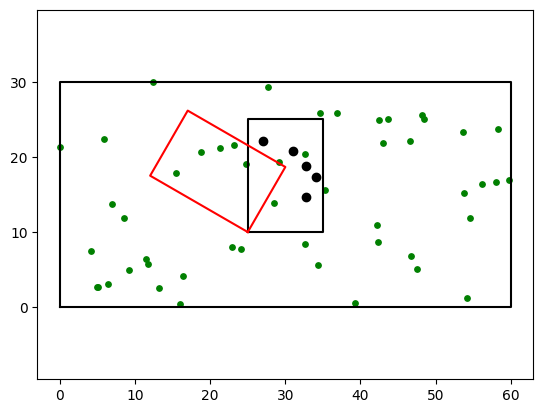

In [23]:
for bh in T2.list_bhs:
    plt.scatter(bh.x,bh.y, c="k")

plt.scatter(x_positions,y_positions, s=15, c="g")

plt.plot((ox2,ox2+Lx2,ox2+Lx2,ox2,ox2),(oy2,oy2,oy2+Ly2,oy2+Ly2,oy2),color="black")

# plot rotated model
plt.plot([points[0, 0], points[1, 0], points[2, 0], points[3, 0], points[0, 0]],
            [points[0, 1], points[1, 1], points[2, 1], points[3, 1], points[0, 1]], 'r')

# plt.imshow(T1.compute_geol_map(color=True),origin="lower",cmap="viridis",alpha=.5, extent=(x0,x1,y0,y1))
plt.plot((x0,x1,x1,x0,x0),(y0,y0,y1,y1,y0),color="black")
plt.axis("equal")

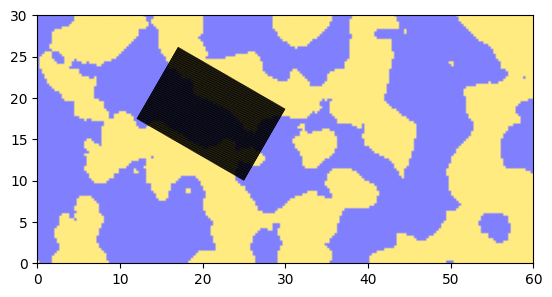

In [24]:
plt.scatter(T2.xcellcenters,T2.ycellcenters, c="k", s=.5, ec="none")
plt.imshow(T1.compute_geol_map(color=True),origin="lower",cmap="viridis",alpha=.5, extent=(x0,x1,y0,y1))

In [25]:
T2.add_geological_map("geol_map.tif")

Geological map added


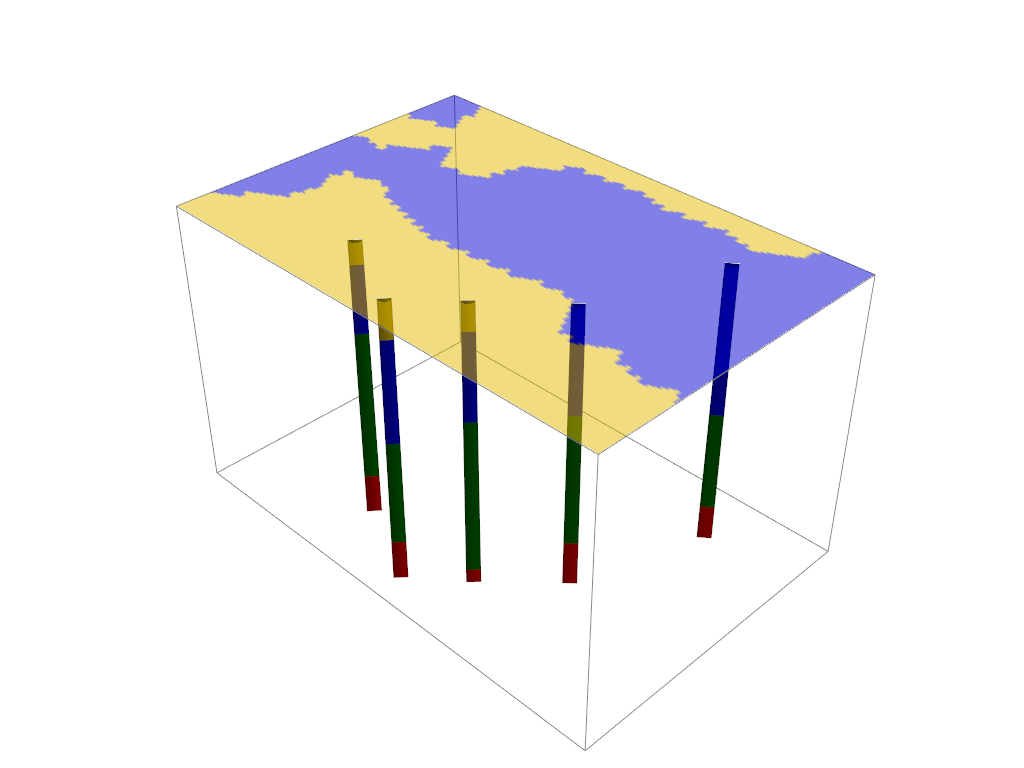

In [26]:
import pyvista as pv

p = pv.Plotter(notebook=True)

T2.plot_geol_map(plotter=p)
T2.plot_bhs(plotter=p)

p.add_bounding_box()

p.show()

In [27]:
T2.erase_hd()

Hard data reset


In [28]:
T2.process_geological_map(step=10, typ="uniform")

Geological map extracted - processus ended successfully


In [29]:
T2.process_bhs(reprocess=True)

Hard data reset
##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


In [30]:
T2.compute_surf(2)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A


A: time elapsed for computing surface 0.4263911247253418 s

#### COMPUTING SURFACE OF UNIT B


B: time elapsed for computing surface 0.42238450050354004 s

#### COMPUTING SURFACE OF UNIT C


C: time elapsed for computing surface 0.4213833808898926 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.12211155891418457 s

#### COMPUTING SURFACE OF UNIT A


A: time elapsed for computing surface 0.43139171600341797 s

#### COMPUTING SURFACE OF UNIT B


B: time elapsed for computing surface 0.4083709716796875 s

#### COMPUTING SURFACE OF UNIT C


C: time elapsed for computing surface 0.4161412715911865 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.12663888931274414 s
##########################


### 2.8078415393829346: Total time elapsed for computing surfaces ###


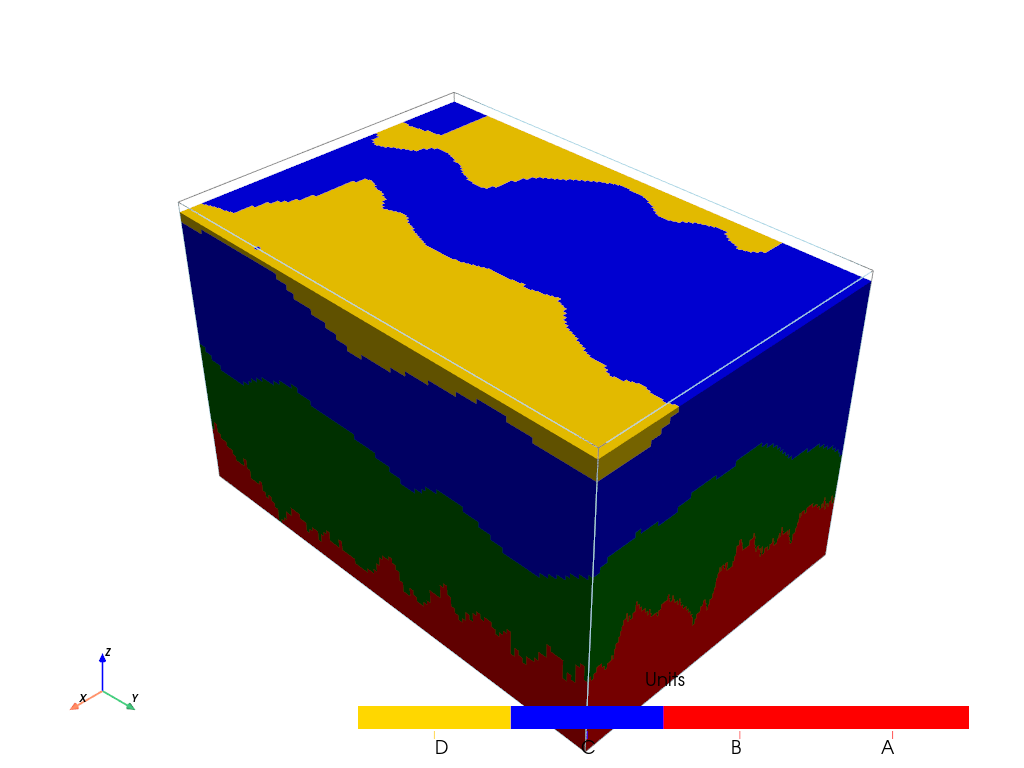

In [31]:
T2.plot_units(1)

Let's make a cross-section of our model. 
There is two solutions: 
- 1. we provide the list of points in the original coordinate system, 
- 2. we provide the list of points in the rotated coordinate system. If so, we need to explicitely set ``rotate`` (in ``T2.plot_cross_section``) as False because the points are already in the rotated coordinate system.

Here the two options are shown.

Let us first draw a cross-section of the model in the original coordinate system.

In [32]:
draw = False

# cross-section

if draw:
    %matplotlib tk
    gmap = T1.compute_geol_map(0, color = True)
    plt.imshow(gmap, origin="lower", extent = [T1.ox, T1.xg[-1], T1.oy, T1.yg[-1]])
    plt.scatter([bh.x for bh in T1.list_bhs], [bh.y for bh in T1.list_bhs], c="k", s= 3)


    # plot rotated model
    plt.plot([points[0, 0], points[1, 0], points[2, 0], points[3, 0], points[0, 0]],
                [points[0, 1], points[1, 1], points[2, 1], points[3, 1], points[0, 1]], 'r')
    plt.plot((x0,x1,x1,x0,x0),(y0,y0,y1,y1,y0),color="black")

    list_p = plt.ginput(n=-1, timeout=0)
    plt.close()

else:
    list_p = [(15.241936452927126, 18.19354954381143),
 (25.28225967191881, 19.040323791196272),
 (24.677420923786777, 12.870968560249574)]

We rotate the points using rotate() function

In [33]:
# rotate points
rot_points = np.array(list_p)
rot_points = T2.rotate(rot_points, -T2.rot_angle)

In [34]:
list_p

[(15.241936452927126, 18.19354954381143),
 (25.28225967191881, 19.040323791196272),
 (24.677420923786777, 12.870968560249574)]

In [35]:
rot_points

array([[27.21679028, 22.5475057 ],
       [32.9702799 , 14.27571785],
       [27.32504217, 11.71484595]])

A little plot to show the location of the cross-section in the two systems

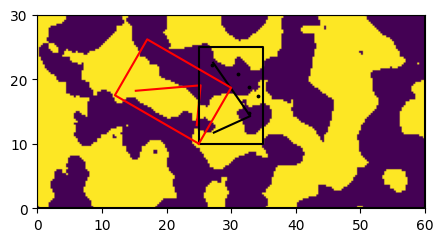

In [36]:
%matplotlib inline
plt.figure(figsize=(5, 15))
plt.imshow(gmap, origin="lower", extent = [T1.ox, T1.xg[-1], T1.oy, T1.yg[-1]])
plt.scatter([bh.x for bh in T2.list_bhs], [bh.y for bh in T2.list_bhs], c="k", s= 3)
plt.plot([i[0] for i in list_p], [i[1] for i in list_p], c="red")
plt.plot([i[0] for i in rot_points], [i[1] for i in rot_points], c="black")

plt.plot((ox2,ox2+Lx2,ox2+Lx2,ox2,ox2),(oy2,oy2,oy2+Ly2,oy2+Ly2,oy2),color="black")

# plot rotated model
plt.plot([points[0, 0], points[1, 0], points[2, 0], points[3, 0], points[0, 0]],
            [points[0, 1], points[1, 1], points[2, 1], points[3, 1], points[0, 1]], 'r')

# plt.imshow(T1.compute_geol_map(color=True),origin="lower",cmap="viridis",alpha=.5, extent=(x0,x1,y0,y1))
plt.plot((x0,x1,x1,x0,x0),(y0,y0,y1,y1,y0),color="black")

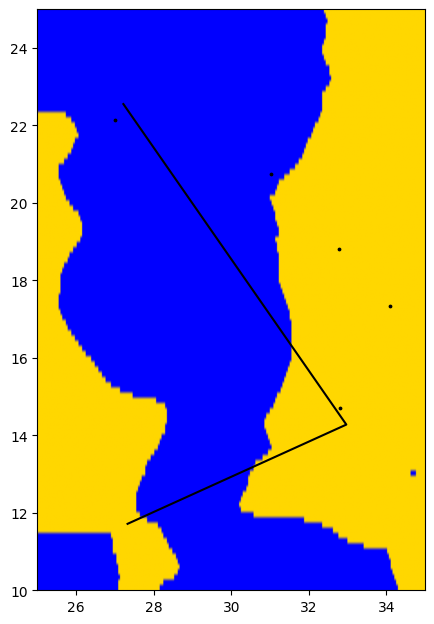

In [37]:
%matplotlib inline
plt.figure(figsize=(5, 15))
gmap = T2.compute_geol_map(1, color = True)
plt.imshow(gmap, origin="lower", extent = [T2.ox, T2.xg[-1], T2.oy, T2.yg[-1]])
plt.plot([i[0] for i in rot_points], [i[1] for i in rot_points], c="black")
plt.scatter([bh.x for bh in T2.list_bhs], [bh.y for bh in T2.list_bhs], c="k", s= 3)

Cross-section with points in original coordinate system

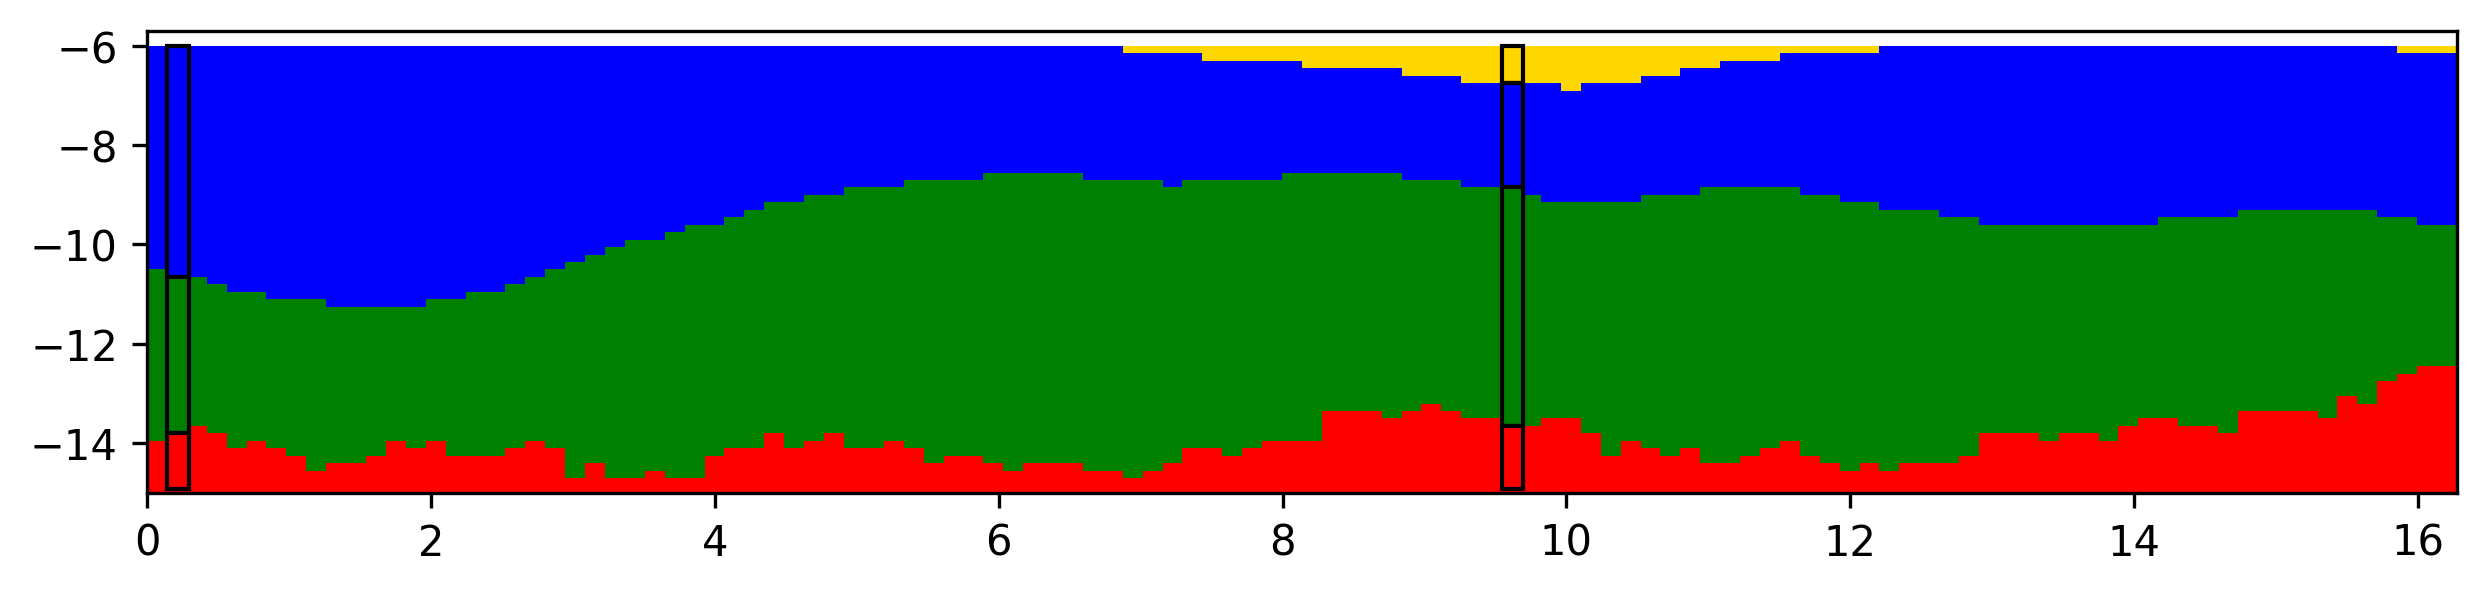

In [38]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(13, 2), dpi=300)
for iu in range(1):
    T2.plot_cross_section(list_p, iu=iu, ratio_aspect=5, dist_max=2, width=.15, rotate=True, bh_type="units", ax=ax)
    # plt.show()

Now with rotated points

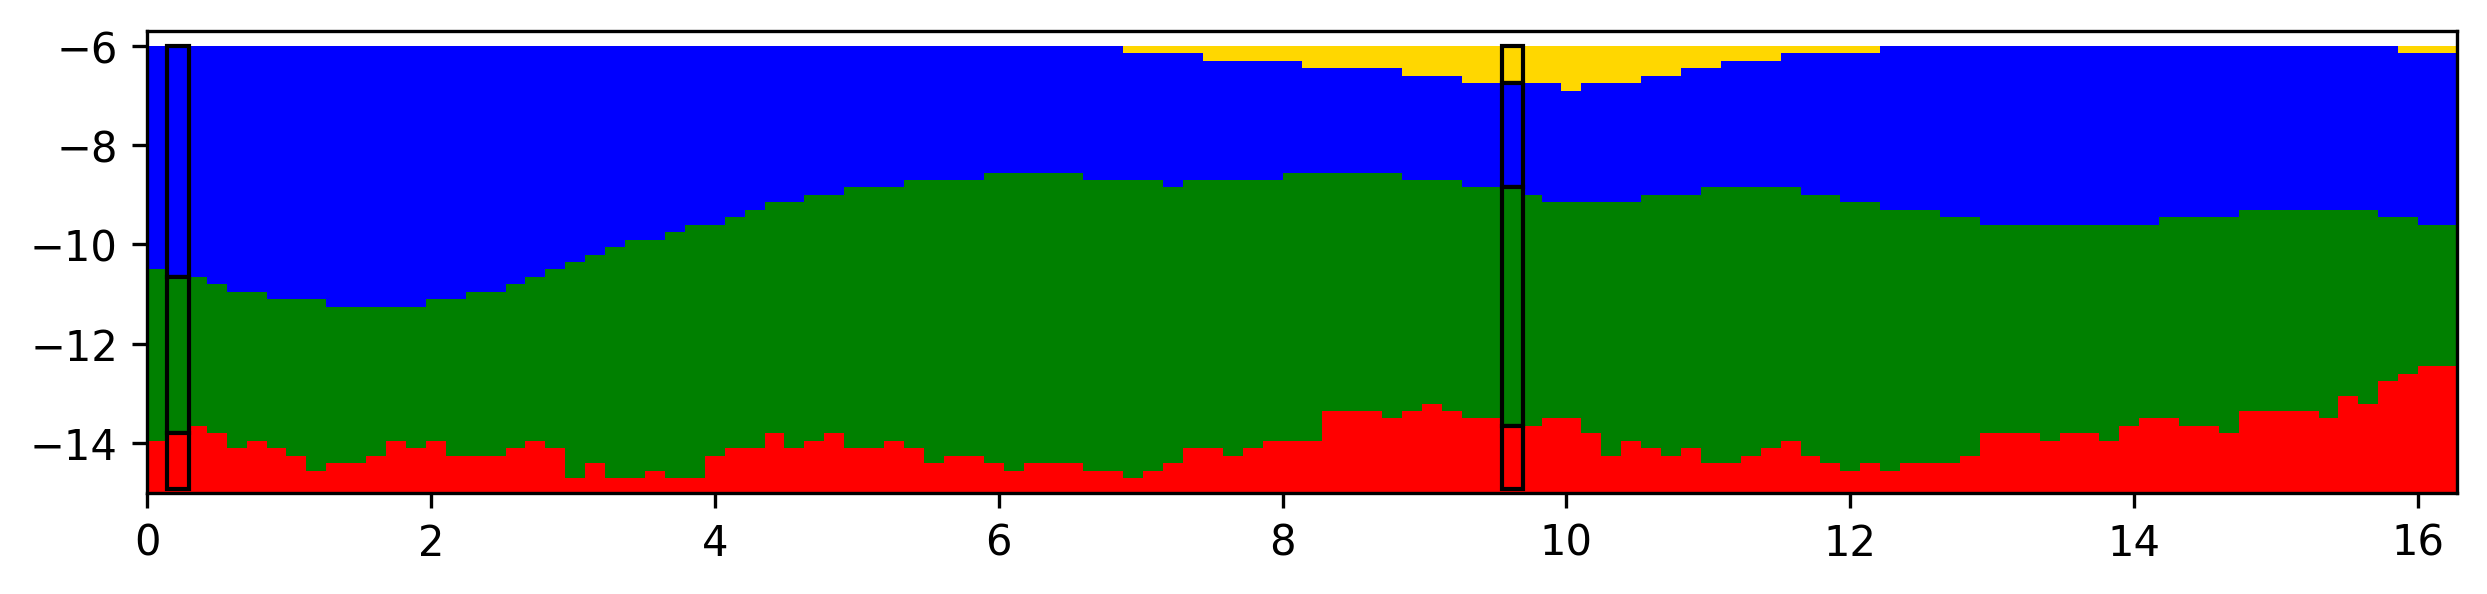

In [39]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(13, 2), dpi=300)
for iu in range(1):
    T2.plot_cross_section(rot_points, iu=iu, ratio_aspect=5, dist_max=2, width=.15, rotate=False, ax=ax)
    # plt.show()

### Testing the export and import of the model

In [40]:
ArchPy.inputs.save_project(T2)

Project saved successfully


True

In [41]:
T3 = ArchPy.inputs.import_project(project_name="Example_rotation", ws="workspace_ref")

### IMPORTING PROJECT Example_rotation IN workspace_ref DIRECTORY ### 

Unit A: Surface added for interpolation
Facies basement added to unit A


Unit B: TI added
Unit B: Surface added for interpolation
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Unit C: Surface added for interpolation
Facies Clay added to unit C
Facies Silt added to unit C
Unit D: Surface added for interpolation
Facies Sand added to unit D
Facies Gravel added to unit D
Facies GM added to unit D
Facies SM added to unit D
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added
Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Borehole fake2 added
Borehole fake24 added
Borehole fake29 added
Borehole fake39 added
Borehole fake46 added
Geological map added


 ##LOADING RESULTS## 


#### Units loaded ####
Facies results file not found
Property results file not found
#### Surfaces loaded ####
#### Bottom surfaces loaded ####


 ### SUCCESSFUL IMPORT ### 



In [42]:
T3.process_geological_map(step=5)
T3.process_bhs(reprocess=True)

Geological map extracted - processus ended successfully


Hard data reset
##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept
Multiples boreholes ['raster_bh', 'contact_bh'] were found inside the same cell, the deepest will be kept


In [43]:
T3.compute_surf(2)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A


A: time elapsed for computing surface 0.9882767200469971 s

#### COMPUTING SURFACE OF UNIT B


B: time elapsed for computing surface 0.9894039630889893 s

#### COMPUTING SURFACE OF UNIT C


simulate2D: warnings encountered (1 times in all):
#  1: WARNING 02005: inequality has been relaxed for consistency (solving kriging system, inequality)
C: time elapsed for computing surface 1.6881399154663086 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.1261153221130371 s

#### COMPUTING SURFACE OF UNIT A


A: time elapsed for computing surface 1.0053918361663818 s

#### COMPUTING SURFACE OF UNIT B


B: time elapsed for computing surface 0.9949040412902832 s

#### COMPUTING SURFACE OF UNIT C


simulate2D: warnings encountered (1 times in all):
#  1: WARNING 02005: inequality has been relaxed for consistency (solving kriging system, inequality)
C: time elapsed for computing surface 1.6835274696350098 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.12511491775512695 s
##########################


### 7.632903099060059: Total time elapsed for computing surfaces ###


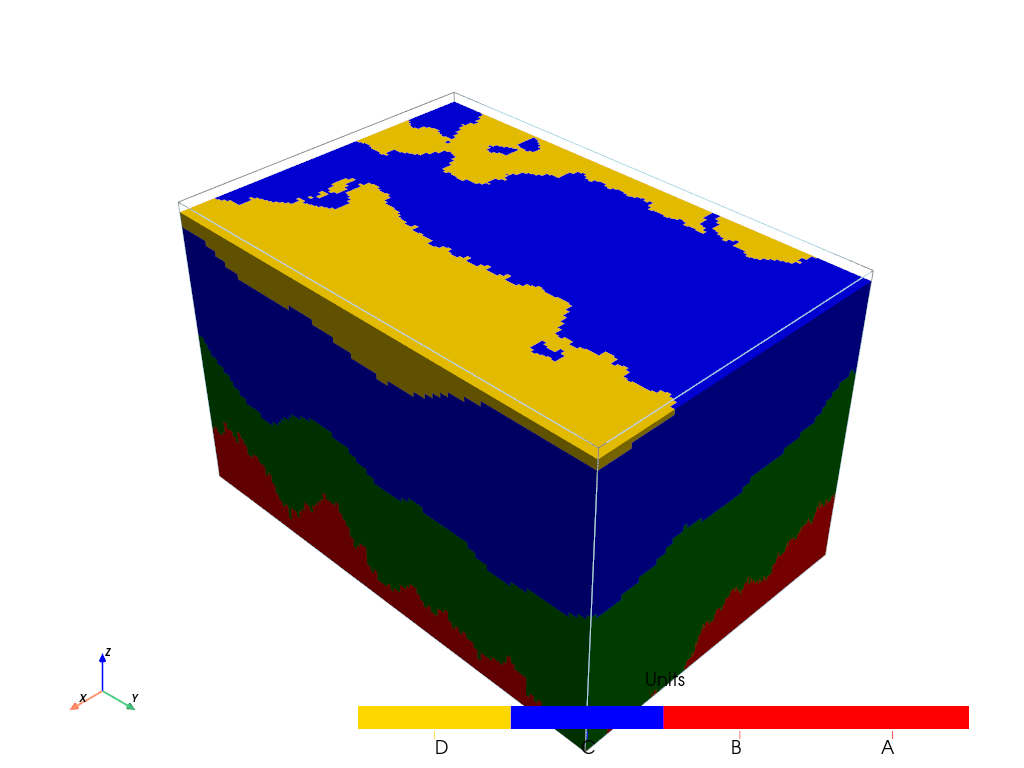

In [44]:
T3.plot_units()